# Notebook 12 b) Sentiment Predictive Model for the Aspect Dataset

This notebook seeks to train a model to predict sentiment on the full dataset based only on the noun phrases previously extracted but using neural network models instead of machine learning.

* Section 1 - Import libraries and data
* Section 2 - Data preprocessing
* Section 3 - Building a sentiment model (Models 1 to 5 based on the best simple networks from Notebook 8)
* Section 4 - Summary results table

Datasets need to run file:
* combined_sentiment.csv
* combined_sentiment_test.csv

Models saved to:
* SentimentModels1
* SentimentModels2
* SentimentModels3
* SentimentModels4
* SentimentModels5

Final results:

* results_sentiment.csv


# Section 1: Import libraries and data

In [1]:
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer
import keras
from keras.models import Sequential
from keras.layers import Dense,Flatten,Embedding,LSTM,Dropout,SpatialDropout1D,Conv1D,GlobalMaxPooling1D,SimpleRNN,LSTM,GRU,Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.utils import to_categorical
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
import imblearn
from imblearn.over_sampling import SMOTE

import os
import pickle

import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score,precision_score,recall_score,f1_score,confusion_matrix,classification_report
from sklearn.utils import class_weight

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Bring in training and test sets from Notebook 11 (visualising topic models)
df_train = pd.read_csv("combined_sentiment.csv",index_col = 0)
df_test = pd.read_csv("combined_sentiment_test.csv",index_col = 0)

In [3]:
# Combine train and test set
df_combined_all = pd.concat([df_train, df_test],axis = 0,ignore_index = True)
df_combined_all.shape

(73027, 15)

# Section 2: Data preprocessing

In [4]:
# Choose columns, replace incorrect category label and relabel columns
df_train = df_train[["OrigInd","Category","noun_phrases","Topic Count","Sentiment","Score"]]
df_train.columns = ["OrigInd","Category","Noun Phrases","Aspect","Sentiment","Polarity"]
df_test = df_test[["OrigInd","Category","noun_phrases","Topic","Sentiment","Score"]]
df_test["Category"].replace({"Attract": "Attractions"}, inplace=True)
df_test.columns = ["OrigInd","Category","Noun Phrases","Aspect","Sentiment","Polarity"]

In [5]:
# Get Category distribution
df_combined_all["Category"].value_counts()

Food             40587
Accommodation    24670
Attractions       7560
Attract            210
Name: Category, dtype: int64

In [6]:
df_combined_all.head(2)

,Unnamed: 0.1,OrigInd,Category,Town,Rating,all_text,cleaned,noun_phrases,nouns,Topic Count,Topic TFIDF,Sentiment,Score,Sentence,Topic
0,0,0,Accommodation,Bognor,4,"Nice break, shame about the accommodation... W...",nice break shame accommodation booked night st...,shame accommodation,"['shame', 'accommodation']",VFM,VisitExp,-0.4767,negative,NaN,NaN
1,1,0,Accommodation,Bognor,4,"Nice break, shame about the accommodation... W...",nice break shame accommodation booked night st...,night stay december post-christmas,"['night', 'post-christmas']",Hotel Location,Restaurant,0.0000,neutral,NaN,NaN


In [7]:
# Get Polarity distribution
df_combined_all["Score"].value_counts()

neutral     39099
positive    29513
negative     4415
Name: Score, dtype: int64

<BarContainer object of 3 artists>

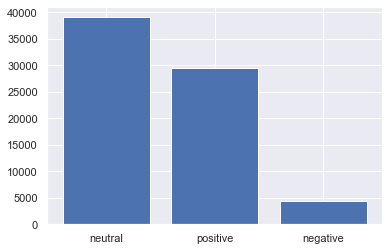

In [8]:
# Distribution of polarities
sent = pd.DataFrame(df_combined_all["Score"].value_counts())
plt.bar(sent.index,sent["Score"])

The dataset is imbalanced

In [9]:
# Drop the neutral sentiment and set 0 to positive and 1 to negative
df_combined_all = df_combined_all[df_combined_all["Score"]!="neutral"]
df_combined_all["Score"].replace({"positive": 0,"negative":1}, inplace=True)

In [10]:
df_combined_all.to_csv("combinedall.csv")

## Define X and y and split into training, valuation and test sets

In [11]:
X = df_combined_all["noun_phrases"]
y = df_combined_all["Score"]

In [12]:
# Train, validation, test split
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y,test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, stratify = y_test,test_size=0.50, random_state=42) 

In [13]:
print(X_train.shape,X_val.shape,X_test.shape,y_train.shape,y_val.shape,y_test.shape)

(27142,) (3393,) (3393,) (27142,) (3393,) (3393,)


In [14]:
y_train.value_counts()

0    23610
1     3532
Name: Score, dtype: int64

In [15]:
y_val.value_counts()

0    2952
1     441
Name: Score, dtype: int64

In [16]:
y_test.value_counts()

0    2951
1     442
Name: Score, dtype: int64

## Distribution of noun phrases

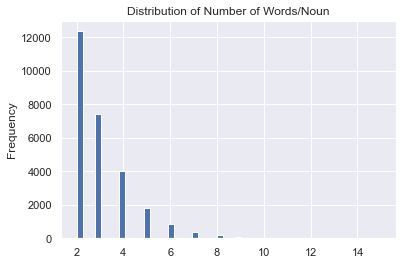

In [17]:
pd.DataFrame(X_train)["noun_phrases"].str.split().apply(len).plot.hist(bins = 50, title = "Distribution of Number of Words/Noun")
plt.show()

In [18]:
pd.DataFrame(X_train)["noun_phrases"].str.split().apply(len).max()

15

## Encoding X values

In [23]:
def tok(X_train, X_val, X_test):
    tokenizer = Tokenizer(num_words = 5000)
    tokenizer.fit_on_texts(X_train)
    X_train_s = tokenizer.texts_to_sequences(X_train)
    X_val_s = tokenizer.texts_to_sequences(X_val)
    X_test_s = tokenizer.texts_to_sequences(X_test)
    X_train_w = pad_sequences(np.array(X_train_s,dtype = "object"), maxlen=20, padding="post", truncating="post", value=0.0)
    X_val_w = pad_sequences(np.array(X_val_s,dtype = "object"), maxlen=20, padding="post", truncating="post", value=0.0)
    X_test_w = pad_sequences(np.array(X_test_s, dtype = "object"), maxlen = 20, padding = "post", truncating = "post", value = 0.0)
    
    return tokenizer, X_train_w, X_val_w, X_test_w

In [24]:
# Apply function to X training, validation and test sets
tok,X_train_w, X_val_w, X_test_w = tok(X_train, X_val, X_test)

In [25]:
# Save tokenizer objects for use in the combined final model
def tok_save(name,tokenizer):
    with open(name, 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
# Save tokenizer pickle files
tok_save('tok_sent.pickle',tok)

In [28]:
index_word = {v:k for k,v in tok.word_index.items()}

In [27]:
#print(tokenizer.word_counts)

In [ ]:
#print(tokenizer.word_index)

# Section 3: Building a Sentiment Model

In [29]:
# Visualise the training and test accuracies and losses
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Val acc')
    plt.title('Training and Validation accuracy')
    plt.xlabel("Epochs")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Val loss')
    plt.xlabel("Epochs")
    plt.title('Training and Validation loss')
    plt.legend()

In [30]:
# Confusion Matrix function

def class_conf(y_val,y_pred_class):
    classification = classification_report(y_val, y_pred_class)
    fig, ax = plt.subplots()
    cf_matrix = confusion_matrix(y_val, y_pred_class)
    sns.heatmap(cf_matrix, annot = True, fmt = "d",)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title("Confusion Matrix", fontsize = 15)
    _ = ax.xaxis.set_ticklabels(['Good Reviews','Bad Reviews'],fontsize = 8)
    _ = ax.yaxis.set_ticklabels(['Good Reviews', 'Bad Reviews'], fontsize = 8)
    print(classification)  

## Sentiment Model 1

In [31]:
# Metrics function

def metric_results(y_val,y_pred_class):
    accuracy = accuracy_score(y_val, y_pred_class)
    rocauc = roc_auc_score(y_val,y_pred_class)
    precision = precision_score(y_val, y_pred_class, average='binary')
    recall = recall_score(y_val, y_pred_class, average='binary')
    f1 = f1_score(y_val, y_pred_class, average='binary')
          
    
    results = pd.DataFrame({"Accuracy":accuracy, "Precision":precision, "Recall":recall,
                                    "F1":f1,"ROCAUC":rocauc}, index = [0]
                                  )
    return results

In [32]:
# Balanced classes - get weights
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
class_weights

array([0.57479881, 3.84229898])

In [33]:
# Parameters
input_dim = 6000
output_dim = 16
input_length = 20
batch_size = 8
epochs = 50
class_weights = {0:0.57485385,
                 1:3.83984154}

In [34]:
# Simple model with embedding layer and no hidden dense layer, passing the embedding layer to the first layer of the model
model1 = Sequential()
model1.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length=input_length))
model1.add(Flatten())
model1.add(Dense(1, activation='sigmoid'))

In [35]:
# Compile the model
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 16)            96000     
_________________________________________________________________
flatten (Flatten)            (None, 320)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 321       
Total params: 96,321
Trainable params: 96,321
Non-trainable params: 0
_________________________________________________________________
None


In [36]:
# The model will use earlystopping if the valuation loss doesn't decrease after 3 epochs
output_dir = 'model_output/SentimentModels1'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
callbacks = [EarlyStopping(monitor = "val_loss", patience = 5),modelcheckpoint]

In [37]:
# Model using keras embeddings
history = model1.fit(X_train_w,y_train,
                    epochs=epochs,
                    verbose=2,
                    callbacks = callbacks,
                    validation_data=(X_val_w, y_val),
                    batch_size=batch_size,
                    class_weight = class_weights)

Epoch 1/50
3393/3393 - 2s - loss: 0.2126 - accuracy: 0.9090 - val_loss: 0.0821 - val_accuracy: 0.9685
Epoch 2/50
3393/3393 - 2s - loss: 0.0448 - accuracy: 0.9866 - val_loss: 0.0428 - val_accuracy: 0.9856
Epoch 3/50
3393/3393 - 2s - loss: 0.0220 - accuracy: 0.9932 - val_loss: 0.0357 - val_accuracy: 0.9882
Epoch 4/50
3393/3393 - 2s - loss: 0.0124 - accuracy: 0.9965 - val_loss: 0.0281 - val_accuracy: 0.9906
Epoch 5/50
3393/3393 - 2s - loss: 0.0072 - accuracy: 0.9980 - val_loss: 0.0341 - val_accuracy: 0.9876
Epoch 6/50
3393/3393 - 2s - loss: 0.0047 - accuracy: 0.9987 - val_loss: 0.0313 - val_accuracy: 0.9891
Epoch 7/50
3393/3393 - 2s - loss: 0.0034 - accuracy: 0.9991 - val_loss: 0.0289 - val_accuracy: 0.9900
Epoch 8/50
3393/3393 - 2s - loss: 0.0022 - accuracy: 0.9993 - val_loss: 0.0293 - val_accuracy: 0.9903
Epoch 9/50
3393/3393 - 2s - loss: 0.0019 - accuracy: 0.9994 - val_loss: 0.0323 - val_accuracy: 0.9903


In [38]:
# Print training and test accuracies
loss, accuracy = model1.evaluate(X_train_w, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model1.evaluate(X_val_w, y_val, verbose=False)
print("Validation Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9999
Validation Accuracy:  0.9903


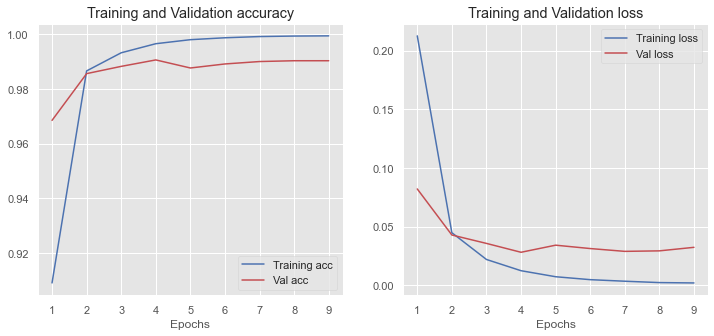

In [39]:
plot_history(history)

In [40]:
# Load model weights from epoch with best validation accuracy
model1.load_weights(output_dir+"/weights.04.hdf5")

In [41]:
# Get predicted y values and predicted classes
y_pred_prob = model1.predict(X_val_w)
y_pred_class = (model1.predict(X_val_w) > 0.5).astype("int32")

In [42]:
# Create dataframe with y pred probabilities, classes and y actual
ydf = pd.DataFrame(list(zip(y_pred_prob, y_pred_class,y_val,)), columns=['y_prob','y_pred_class', 'y'])
ydf.head()

,y_prob,y_pred_class,y
0,[1.0],[1],1
1,[1.5400552e-07],[0],0
2,[0.032568038],[0],0
3,[2.2680586e-05],[0],0
4,[0.00438118],[0],0


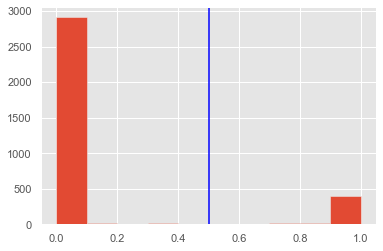

In [43]:
# Graph to show distribution of probabilities produced by the model
plt.hist(y_pred_prob)
_ = plt.axvline(x=0.5, color='blue')

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2952
           1       0.97      0.96      0.96       441

    accuracy                           0.99      3393
   macro avg       0.98      0.98      0.98      3393
weighted avg       0.99      0.99      0.99      3393



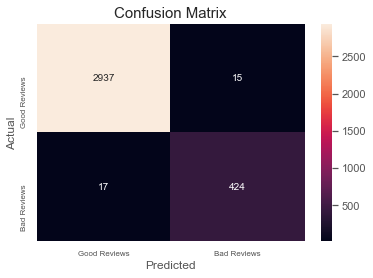

In [44]:
# Print metrics
class_conf(y_val,y_pred_class)

In [45]:
# Summarised results
mod1_results = metric_results(y_val,y_pred_class)
mod1_results

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.990569,0.965831,0.961451,0.963636,0.978185


High accuracy but recall on the low side

## Sentiment Model 2

In [46]:
model2 = Sequential()
model2.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length=input_length))
model2.add(Flatten())
model2.add(Dense(64, activation='relu', input_shape=(1600,)))
model2.add(Dense(1, activation='sigmoid'))

In [47]:
# Compile the model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 16)            96000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                20544     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 116,609
Trainable params: 116,609
Non-trainable params: 0
_________________________________________________________________
None


In [48]:
output_dir = 'model_output/SentimentModels2'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")

callbacks = [EarlyStopping(monitor = "val_loss", patience = 5),modelcheckpoint]

In [49]:
# Model using keras embeddings
history = model2.fit(X_train_w, y_train,
                    epochs=epochs,
                    verbose=2,
                    callbacks = callbacks,
                    validation_data=(X_val_w, y_val),
                    batch_size=batch_size,class_weight = class_weights)

Epoch 1/50
3393/3393 - 2s - loss: 0.1400 - accuracy: 0.9318 - val_loss: 0.0545 - val_accuracy: 0.9800
Epoch 2/50
3393/3393 - 2s - loss: 0.0263 - accuracy: 0.9913 - val_loss: 0.0318 - val_accuracy: 0.9909
Epoch 3/50
3393/3393 - 2s - loss: 0.0088 - accuracy: 0.9969 - val_loss: 0.0336 - val_accuracy: 0.9891
Epoch 4/50
3393/3393 - 2s - loss: 0.0050 - accuracy: 0.9986 - val_loss: 0.0423 - val_accuracy: 0.9894
Epoch 5/50
3393/3393 - 2s - loss: 0.0041 - accuracy: 0.9987 - val_loss: 0.0407 - val_accuracy: 0.9891
Epoch 6/50
3393/3393 - 2s - loss: 0.0024 - accuracy: 0.9994 - val_loss: 0.0502 - val_accuracy: 0.9897
Epoch 7/50
3393/3393 - 2s - loss: 0.0015 - accuracy: 0.9993 - val_loss: 0.0476 - val_accuracy: 0.9894


In [50]:
# Print training and test accuracies
loss, accuracy = model2.evaluate(X_train_w, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model2.evaluate(X_val_w, y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9998
Testing Accuracy:  0.9894


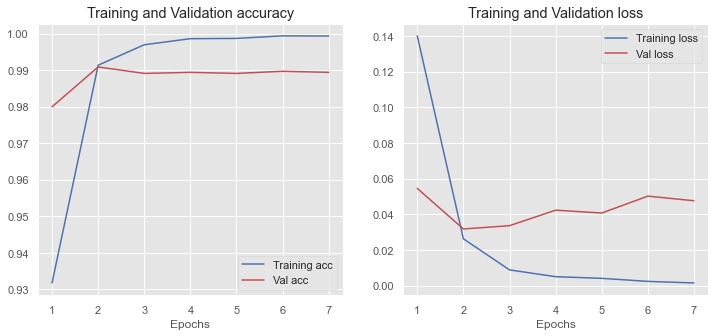

In [51]:
plot_history(history)

In [58]:
# Load model weights from epoch with best validation accuracy
model2.load_weights(output_dir+"/weights.02.hdf5")

In [59]:
# Get predicted y values and predicted classes
y_pred_prob = model2.predict(X_val_w)
y_pred_class = (model2.predict(X_val_w) > 0.5).astype("int32")

In [60]:
# Create dataframe with y pred probabilities, classes and y actual
ydf = pd.DataFrame(list(zip(y_pred_prob, y_pred_class,y_val,)), columns=['y_prob','y_pred_class', 'y'])
ydf.head()

,y_prob,y_pred_class,y
0,[0.9999932],[1],1
1,[5.989902e-06],[0],0
2,[0.0094358325],[0],0
3,[4.5852257e-06],[0],0
4,[0.00016281009],[0],0


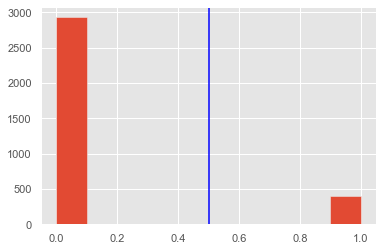

In [61]:
# Graph to show distribution of probabilities produced by the model
plt.hist(y_pred_prob)
_ = plt.axvline(x=0.5, color='blue')

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2952
           1       0.98      0.95      0.96       441

    accuracy                           0.99      3393
   macro avg       0.98      0.97      0.98      3393
weighted avg       0.99      0.99      0.99      3393



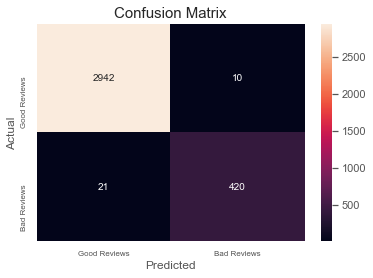

In [62]:
# Print metrics
class_conf(y_val,y_pred_class)

In [63]:
# Summarised results
mod2_results = metric_results(y_val,y_pred_class)
mod2_results

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.990864,0.976744,0.952381,0.964409,0.974497


Accuracy still very good and recall improved

## Sentiment Model 3

In [64]:
# Network with a hidden layer with more neurons in the dense layer and with dropout of 50%
model3 = Sequential()
model3.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length=input_length))
model3.add(Flatten())
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(rate=0.5))
model3.add(Dense(1, activation='sigmoid')) 

In [65]:
# Compile the model
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model3.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 16)            96000     
_________________________________________________________________
flatten_2 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               41088     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 137,217
Trainable params: 137,217
Non-trainable params: 0
_________________________________________________________________
None


In [66]:
output_dir = 'model_output/SentimentModels3'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")

callbacks = [EarlyStopping(monitor = "val_loss", patience = 5),modelcheckpoint]

In [67]:
# Model using keras embeddings
history = model3.fit(X_train_w, y_train,
                    epochs=epochs,
                    verbose=2,
                    callbacks = callbacks,
                    validation_data=(X_val_w, y_val),
                    batch_size=batch_size,class_weight = class_weights)

Epoch 1/50
3393/3393 - 2s - loss: 0.1549 - accuracy: 0.9356 - val_loss: 0.0508 - val_accuracy: 0.9844
Epoch 2/50
3393/3393 - 2s - loss: 0.0279 - accuracy: 0.9910 - val_loss: 0.0382 - val_accuracy: 0.9888
Epoch 3/50
3393/3393 - 2s - loss: 0.0101 - accuracy: 0.9969 - val_loss: 0.0384 - val_accuracy: 0.9882
Epoch 4/50
3393/3393 - 2s - loss: 0.0050 - accuracy: 0.9985 - val_loss: 0.0441 - val_accuracy: 0.9912
Epoch 5/50
3393/3393 - 2s - loss: 0.0038 - accuracy: 0.9988 - val_loss: 0.0702 - val_accuracy: 0.9859
Epoch 6/50
3393/3393 - 2s - loss: 0.0041 - accuracy: 0.9987 - val_loss: 0.0512 - val_accuracy: 0.9897
Epoch 7/50
3393/3393 - 2s - loss: 0.0022 - accuracy: 0.9994 - val_loss: 0.0574 - val_accuracy: 0.9906


In [68]:
# Print training and test accuracies
loss, accuracy = model3.evaluate(X_train_w, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model3.evaluate(X_val_w, y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9998
Testing Accuracy:  0.9906


In [101]:
model3.save("Sentiment.h5")

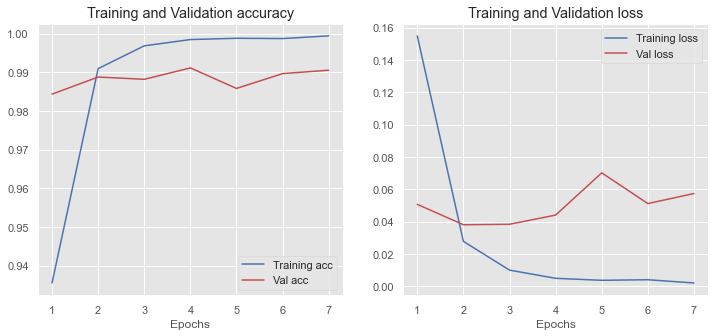

In [69]:
plot_history(history)

In [70]:
# Load model weights from epoch with best validation accuracy
model3.load_weights(output_dir+"/weights.04.hdf5")

In [71]:
# Get predicted y values and predicted classes
y_pred_prob = model3.predict(X_val_w)
y_pred_class = (model3.predict(X_val_w) > 0.5).astype("int32")

In [72]:
# Create dataframe with y pred probabilities, classes and y actual
ydf = pd.DataFrame(list(zip(y_pred_prob, y_pred_class,y_val,)), columns=['y_prob','y_pred_class', 'y'])
ydf.head()

,y_prob,y_pred_class,y
0,[1.0],[1],1
1,[1.7594096e-10],[0],0
2,[0.00021612644],[0],0
3,[8.456058e-09],[0],0
4,[2.1093729e-05],[0],0


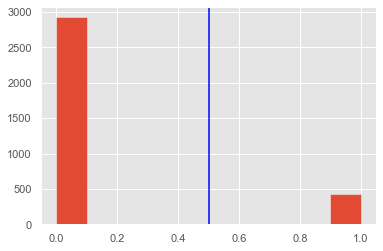

In [73]:
# Graph to show distribution of probabilities produced by the model
plt.hist(y_pred_prob)
_ = plt.axvline(x=0.5, color='blue')

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2952
           1       0.96      0.97      0.97       441

    accuracy                           0.99      3393
   macro avg       0.98      0.98      0.98      3393
weighted avg       0.99      0.99      0.99      3393



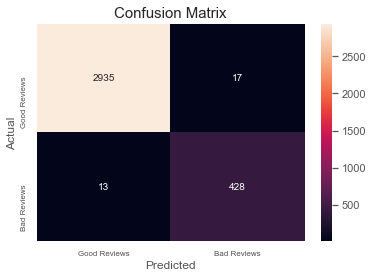

In [74]:
# Print metrics
class_conf(y_val,y_pred_class)

In [75]:
# Summarised results
mod3_results = metric_results(y_val,y_pred_class)
mod3_results

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.991158,0.961798,0.970522,0.96614,0.982381


Accuracy and recall slightly reduced on the previous model

## Sentiment Model 4

In [76]:
# Dense model with 2 hidden dense layers and dropout on each
model4 = Sequential()
model4.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length=input_length))
model4.add(Flatten())
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(rate=0.5))
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(rate = 0.5))
model4.add(Dense(1, activation='sigmoid')) 

In [77]:
# Compile the model
model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model4.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 20, 16)            96000     
_________________________________________________________________
flatten_3 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               41088     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [78]:
output_dir = 'model_output/SentimentModels4'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")

callbacks = [EarlyStopping(monitor = "val_loss", patience = 5),modelcheckpoint]

In [79]:
# Model using keras embeddings
history = model4.fit(X_train_w, y_train,
                    epochs=epochs,
                    verbose=2,
                    callbacks = callbacks,
                    validation_data=(X_val_w, y_val),
                    batch_size=batch_size,class_weight = class_weights)

Epoch 1/50
3393/3393 - 2s - loss: 0.1566 - accuracy: 0.9436 - val_loss: 0.0499 - val_accuracy: 0.9838
Epoch 2/50
3393/3393 - 2s - loss: 0.0335 - accuracy: 0.9909 - val_loss: 0.0400 - val_accuracy: 0.9879
Epoch 3/50
3393/3393 - 2s - loss: 0.0117 - accuracy: 0.9970 - val_loss: 0.0425 - val_accuracy: 0.9888
Epoch 4/50
3393/3393 - 2s - loss: 0.0063 - accuracy: 0.9984 - val_loss: 0.0619 - val_accuracy: 0.9885
Epoch 5/50
3393/3393 - 2s - loss: 0.0093 - accuracy: 0.9976 - val_loss: 0.0575 - val_accuracy: 0.9882
Epoch 6/50
3393/3393 - 2s - loss: 0.0038 - accuracy: 0.9989 - val_loss: 0.0883 - val_accuracy: 0.9879
Epoch 7/50
3393/3393 - 2s - loss: 0.0037 - accuracy: 0.9992 - val_loss: 0.0756 - val_accuracy: 0.9891


In [80]:
# Print training and test accuracies
loss, accuracy = model4.evaluate(X_train_w, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model4.evaluate(X_val_w, y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.9891


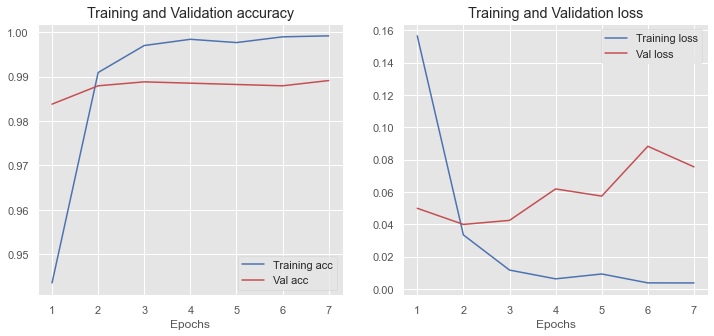

In [81]:
plot_history(history)

In [82]:
# Load model weights from epoch with best validation accuracy
model4.load_weights(output_dir+"/weights.07.hdf5")

In [83]:
# Get predicted y values and predicted classes
y_pred_prob = model4.predict(X_val_w)
y_pred_class = (model4.predict(X_val_w) > 0.5).astype("int32")

In [84]:
# Create dataframe with y pred probabilities, classes and y actual
ydf = pd.DataFrame(list(zip(y_pred_prob, y_pred_class,y_val,)), columns=['y_prob','y_pred_class', 'y'])
ydf.head()

,y_prob,y_pred_class,y
0,[1.0],[1],1
1,[4.273807e-19],[0],0
2,[6.523137e-10],[0],0
3,[7.697954e-15],[0],0
4,[5.911291e-09],[0],0


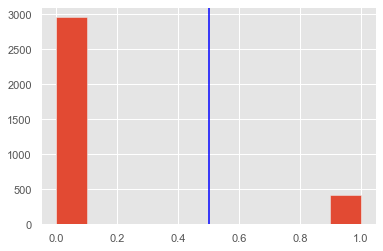

In [85]:
# Graph to show distribution of probabilities produced by the model
plt.hist(y_pred_prob)
_ = plt.axvline(x=0.5, color='blue')

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2952
           1       0.98      0.94      0.96       441

    accuracy                           0.99      3393
   macro avg       0.98      0.97      0.98      3393
weighted avg       0.99      0.99      0.99      3393



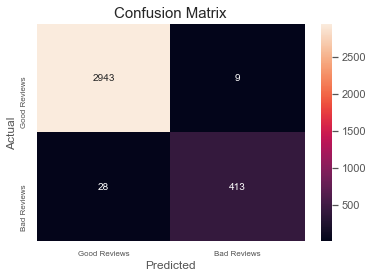

In [86]:
# Print metrics
class_conf(y_val,y_pred_class)

In [87]:
# Summarised results
mod4_results = metric_results(y_val,y_pred_class)
mod4_results

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.989095,0.978673,0.936508,0.957126,0.96673


No real change to accuracy and recall reduced further

##  Sentiment Model 5

In [88]:
# Dense model with 2 hidden dense layers and dropout on each
model5 = Sequential()
model5.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length=input_length))
model5.add(Flatten())
model5.add(Dense(512, activation='relu'))
model5.add(Dropout(rate=0.5))
model5.add(Dense(256, activation='relu'))
model5.add(Dropout(rate = 0.5))
model5.add(Dense(128,activation = 'relu'))
model5.add(Dense(1, activation='sigmoid')) 

In [89]:
# Compile the model
model5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model5.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 20, 16)            96000     
_________________________________________________________________
flatten_4 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               164352    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)              

In [90]:
output_dir = 'model_output/SentimentModels5'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")

callbacks = [EarlyStopping(monitor = "val_loss", patience = 5),modelcheckpoint]

In [91]:
# Model using keras embeddings
history = model5.fit(X_train_w, y_train,
                    epochs=epochs,
                    verbose=2,
                    callbacks = callbacks,
                    validation_data=(X_val_w, y_val),
                    batch_size=batch_size,class_weight = class_weights)

Epoch 1/50
3393/3393 - 4s - loss: 0.1513 - accuracy: 0.9464 - val_loss: 0.0521 - val_accuracy: 0.9817
Epoch 2/50
3393/3393 - 3s - loss: 0.0399 - accuracy: 0.9916 - val_loss: 0.0388 - val_accuracy: 0.9882
Epoch 3/50
3393/3393 - 3s - loss: 0.0161 - accuracy: 0.9962 - val_loss: 0.0530 - val_accuracy: 0.9888
Epoch 4/50
3393/3393 - 3s - loss: 0.0111 - accuracy: 0.9970 - val_loss: 0.0702 - val_accuracy: 0.9882
Epoch 5/50
3393/3393 - 3s - loss: 0.0109 - accuracy: 0.9979 - val_loss: 0.0715 - val_accuracy: 0.9873
Epoch 6/50
3393/3393 - 4s - loss: 0.0083 - accuracy: 0.9987 - val_loss: 0.0989 - val_accuracy: 0.9879
Epoch 7/50
3393/3393 - 3s - loss: 0.0064 - accuracy: 0.9987 - val_loss: 0.0754 - val_accuracy: 0.9882


In [92]:
# Print training and test accuracies
loss, accuracy = model5.evaluate(X_train_w, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model5.evaluate(X_val_w, y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9996
Testing Accuracy:  0.9882


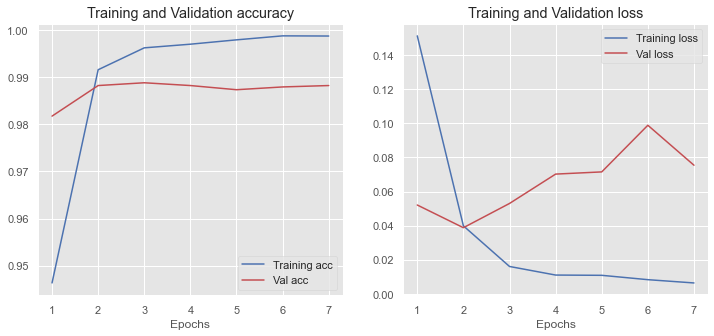

In [93]:
plot_history(history)

In [94]:
# Load model weights from epoch with best validation accuracy
model5.load_weights(output_dir+"/weights.03.hdf5")

In [95]:
# Get predicted y values and predicted classes
y_pred_prob = model5.predict(X_val_w)
y_pred_class = (model5.predict(X_val_w) > 0.5).astype("int32")

In [96]:
# Create dataframe with y pred probabilities, classes and y actual
ydf = pd.DataFrame(list(zip(y_pred_prob, y_pred_class,y_val,)), columns=['y_prob','y_pred_class', 'y'])
ydf.head()

,y_prob,y_pred_class,y
0,[1.0],[1],1
1,[1.6936761e-11],[0],0
2,[0.0040439963],[0],0
3,[2.7320697e-09],[0],0
4,[0.00044122338],[0],0


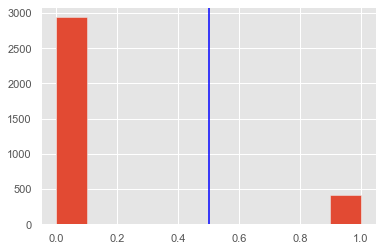

In [97]:
# Graph to show distribution of probabilities produced by the model
plt.hist(y_pred_prob)
_ = plt.axvline(x=0.5, color='blue')

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2952
           1       0.96      0.95      0.96       441

    accuracy                           0.99      3393
   macro avg       0.98      0.97      0.98      3393
weighted avg       0.99      0.99      0.99      3393



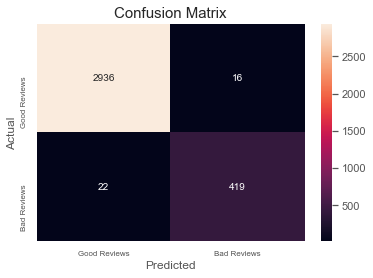

In [98]:
# Print metrics
class_conf(y_val,y_pred_class)

In [99]:
# Summarised results
mod5_results = metric_results(y_val,y_pred_class)
mod5_results

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.9888,0.963218,0.950113,0.956621,0.972347


No improvements in accuracy and recall

# Section 4: Summary of results

In [100]:
models = ["Model1","Model2","Model3","Model4","Model5"]
summary_table = pd.concat([mod1_results,mod2_results,mod3_results,mod4_results,mod5_results])
summary_table.set_index([models],inplace = True)
summary_table.to_csv("results_sentiment.csv")
summary_table.sort_values(by = "Recall",ascending = False)

,Accuracy,Precision,Recall,F1,ROCAUC
Model3,0.991158,0.961798,0.970522,0.966140,0.982381
Model1,0.990569,0.965831,0.961451,0.963636,0.978185
Model2,0.990864,0.976744,0.952381,0.964409,0.974497
Model5,0.988800,0.963218,0.950113,0.956621,0.972347
Model4,0.989095,0.978673,0.936508,0.957126,0.966730


The model that has the best accuracy and recall is Model 4, which is a network with one dense layer. This is in effect a simple binary text classification task, so it is perhaps not surprising that a simple model works fairly well.